In [9]:
from astropy.table import Table
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import fact.io as fio
from irf import irf_from_table, EffectiveArea, EnergyDispersion
%matplotlib inline

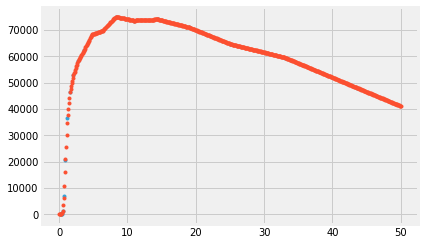

In [10]:
table = Table.read('../fact_irf.fits', hdu='EFFECTIVE AREA')
grid, data =  irf_from_table(table, interpolation_modes={'ENERG':'log'})
aeff = EffectiveArea(grid, data)
bin_centers = aeff.grid[0].to('TeV')

aeff.data[:, 0]
aeff.grid[0]
# area = aeff.evaluate(bin_centers*u.TeV, theta=1.51*u.deg).to('km^2')
plt.plot(bin_centers, aeff.data[:, 0], '.')
x = np.linspace(0, 50, 600)
area = aeff.evaluate(x * u.TeV, theta=0*u.deg)
plt.plot(x, aeff.evaluate(x * u.TeV, theta=0*u.deg), '.')


In [17]:
bins = aeff.grid[0].to('TeV')

def expected_events_in_bins(index, bins):
    events_per_time_and_area = np.array([expected_events_in_range(index, m, n) for m, n in zip(bins[0:], bins[1:])])
    return events_per_time_and_area

def expected_events_in_range(index, e_low, e_high):
    return (1 / (index + 1)) * (e_high**(index + 1) - e_low**(index + 1))

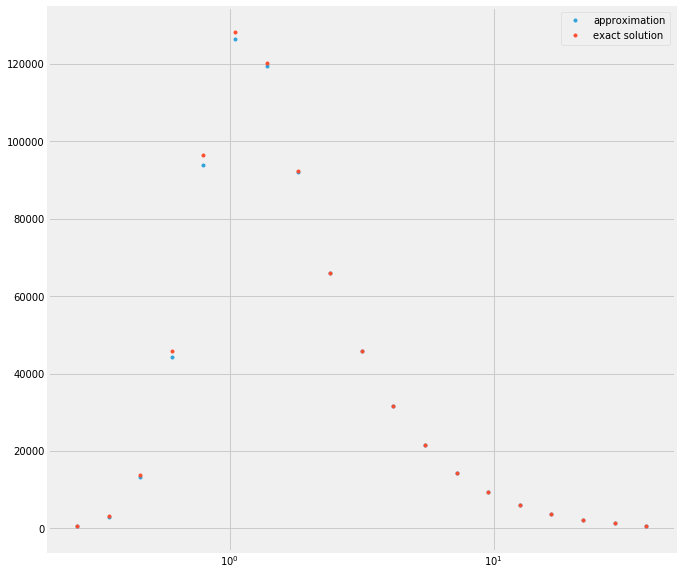

In [27]:
plt.figure(figsize=(10, 10))
from scipy import integrate

class PowerLaw():

    def _power_law(self, energy, index):
        return energy**(index)

    def expected_events_in_bins(self, index, bins, effective_area, t_obs):
        # strip some units
        bins = bins.value
        aeff = lambda e: effective_area.evaluate(e*u.TeV, theta=0.0*u.deg).value
        t_obs = t_obs.value
        
        expectation =  [self._expected_events_in_range(index, m, n, aeff) for m, n in zip(bins[0:], bins[1:])]
        return t_obs * np.array(expectation)

    def _expected_events_in_range(self, index, e_low, e_high, effective_area):
        r = integrate.quad(lambda e: self._power_law(e, index) * effective_area(e), e_low, e_high)
        return r[0]
    
m = PowerLaw()
model = m.expected_events_in_bins(index=-2.62, bins=bins, effective_area=aeff, t_obs=17.7*u.h)


bin_center = np.sqrt(bins[0:-1] * bins[1:])
area = aeff.evaluate(bin_center, theta=0*u.deg).to('m^2')
old_model = expected_events_in_bins(index=-2.62, bins=bins.value) * area * 17.7 


plt.plot(bin_center, model, '.', label='approximation')
plt.plot(bin_center, old_model, '.', label='exact solution')
plt.xscale('log')
plt.legend()
# plt.yscale('log')

In [15]:
bins_2 = np.logspace(np.log10(bins.min().value), np.log10(bins.max().value), 100) * u.TeV
model = expected_events_in_bins(-2.62, bins_2.value, lambda e: aeff.evaluate(e*u.TeV, theta=0.0*u.deg).value, t_obs=17.7*u.h) 

bin_center_2 = np.sqrt(bins_2[0:-1] * bins_2[1:])

plt.plot(bin_center_2, model, '.')
plt.xscale('log')
plt.yscale('log')

NameError: name 'expected_events_in_bins' is not defined